## **Project 6** Consumer goods classification





<!--                         ## Plan
Notebook : project_6_image_processing
I) Image preprocessing

    1) Apllying ML algorithms on initial images
    2) Apllying ML algorithms on cleaned images with classical pretreatement techniques
    3) Apllying ML algorithms on images after dimentionality reduction
    4) Apllying ML algorithms on images after feature extraction with SIFT and HOG -->
    
# Text processing - Automatic text categorization

   ## I) Data mining - EDA (Exploratory Data Analysis)
   
        1) Visualizing the categories of consumer goods and their distribution 
        2) Visualizing the sub-categories 
        3) Number of unique subcategories with respect to their level
        
   ## II) Text preprocessing and cleaning
   
        1) Remove tags, special characters and digits, stopwords, lemmatize 
        2) WordCloud Visualization of the most frequently repeated words in the entire text of descriptions
        
   ## III) Text preparation and clustering
   
        1) TF-IDF implementation before Kmeans clustering
        2) KMeans clustering
        3) Dimentionality reduction -PCA
        4) KMeans clustering
        5) Improving the feature extraction performance for better results
        6) Visualize the results of topics-keywords with pyLDAvis

        
   ## IV) Unsupervised Learning with LDA (Latent Dirichlet Allocation) Topic Modeling

        1) Phrase Modeling: Bi-grams and Tri-grams
                Given a sequence of N-1 words, an N-gram model predicts the most probable word that might follow this sequence
        
        2) Data Transformation: Corpus and Dictionary
                calculating Term Document Frequency
        3) Creating a Base Model and calculating it's Coherence score
        4) Hyper-parameter Tuning
        5) Final model
        6) Visualize the results of  topics-keywords with pyLDAvis
        
        
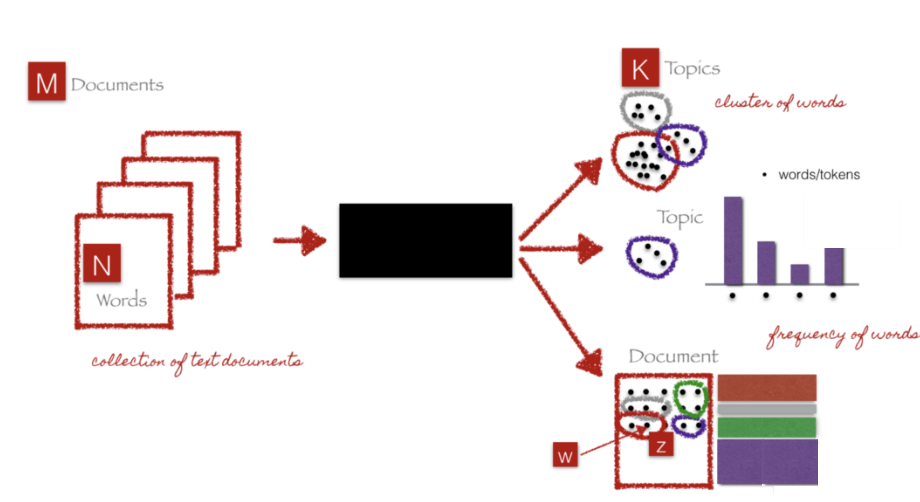

  We build clusters of words. A text is thus a mixture of all the topics, each having a specific weight.
        LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words,
        and each document is a mixture of over a set of topic probabilities.
    

In [41]:

import pandas as pd
import numpy as np
import os
import random

# Visualizations
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import pyLDAvis.gensim_models


# Language Processing
import nltk
import re
from nltk.stem import PorterStemmer # to reduce words to their root
from nltk.corpus import stopwords # to get rid of unnecessary words
from nltk.stem import WordNetLemmatizer # Lemmatize words kepping only root
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer

# Sklearn
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans,  MiniBatchKMeans
from sklearn import manifold
from sklearn.manifold import Isomap
from sklearn import preprocessing
from sklearn.feature_selection import chi2,  SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Measure models performance
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score, davies_bouldin_score, adjusted_rand_score
# Dimentionality reduction
from sklearn.decomposition import PCA, LatentDirichletAllocation


#Gensim for word embedding
import gensim
import gensim.corpora as corpora
import gensim.downloader as gensim_api
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, CoherenceModel

# Save model
import pickle

# Don't show warning messages
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# I) Data mining - EDA

In [15]:
text = pd.read_csv('text.csv') # is the initiale dataframe with all columns

In [38]:
data = pd.read_csv('data.csv') # is the data of only useful columns after selection

In [16]:
data_category_levels = pd.read_csv('data_category_levels.csv') # is the dataframe of categories and subcotegories

Take a look at the data 

In [17]:
text.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [64]:
# display maximum cell content
pd.options.display.max_colwidth = 10000
pd.options.display.max_rows=10000

For text preprocesing we only need text data.

Let's shrink the data to keep only wanted colums.

In [21]:
# Removing unwanted columns from data
data = text.drop(columns=[
    'crawl_timestamp',
    'product_url',
    'pid',
    'retail_price',
    'discounted_price',
    'is_FK_Advantage_product',
    'product_rating',
    'overall_rating',
    'product_specifications',
    'brand'
    
])


In [22]:
data.columns

Index(['uniq_id', 'product_name', 'product_category_tree', 'image',
       'description'],
      dtype='object')

In [13]:
def global_filling_rate(dataframe):
    """Compute and displays global filling rate of a DataFrame"""

    # get the numbers of rows and columns in the dataframe
    nb_rows, nb_columns = dataframe.shape
    print("DataFrame has {} rows and {} columns.".format(nb_rows, nb_columns))

    # get the number of non-Nan data in the dataframe
    nb_data = dataframe.count().sum()

    # computing the filling rate
    filling_rate = nb_data / (nb_rows * nb_columns)
    missing_rate = 1 - filling_rate

    # computing the total missing values
    missing_values = (nb_rows * nb_columns) - nb_data

    # display global results
    print("")
    print("Global filling rate of the DataFrame: {:.2%}".format(filling_rate))
    print("Missing values in the DataFrame: {} ({:.2%})"
          .format(missing_values, missing_rate))

    # compute number of rows with missing values
    mask = dataframe.isnull().any(axis=1)
    rows_w_missing_values = len(dataframe[mask])
    rows_w_missing_values_percentage = rows_w_missing_values / nb_rows

    # display results
    print("")
    print("Number of rows with missing values: {} ({:.2%})"
          .format(rows_w_missing_values, rows_w_missing_values_percentage))

    # compute number of columns with missing values
    mask = dataframe.isnull().any(axis=0)
    cols_w_missing_values = len(dataframe[dataframe.columns[mask]].columns)
    cols_w_missing_values_percentage = cols_w_missing_values / nb_columns

    # display results
    print("Number of columns with missing values: {} ({:.2%})"
          .format(cols_w_missing_values, cols_w_missing_values_percentage))

In [14]:
global_filling_rate(text)

DataFrame has 1050 rows and 15 columns.

Global filling rate of the DataFrame: 97.83%
Missing values in the DataFrame: 341 (2.17%)

Number of rows with missing values: 340 (32.38%)
Number of columns with missing values: 4 (26.67%)


In [4]:
#from Functions_project6 import global_filling_rate
#global_filling_rate(data)

We have the column 'product_category_tree' which contains the branches of the categories of different type of goods that are described in the 'description' column.
We want to see how many categories there are, let's decompose the product category tree.

In [26]:
data.product_category_tree[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [37]:
# Determining the maximum tree depth of categories

cat_depth = data['product_category_tree'].apply(lambda x: x.count('>>')) # counting how many sub-categories are there 
max_depth = cat_depth.max() # maximum numbr of sub-categories


# Creating 6 columns out of  'product_category_tree' column 

def string_cleaning(indx, my_string, level_cols):
    my_string = my_string.replace("[\"", "").replace("\"]", "") #Removing the square brackets from the 
    tab_string = my_string.split(">>") # Spliting on  '>>' separating the categories
    size_tab_str = len(tab_string) 
    tup_str = tuple([tab_string[i].strip() if i<size_tab_str else "" \# removing the white spaces before and after each category
                     for i in np.arange(max_depth) ])
    return tup_str

level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = data['product_category_tree']\
    .apply(lambda s: string_cleaning(s.index, s, level_cols))
data_category_levels = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=level_cols, index=data.index)

In [24]:
data_category_levels.head(1)

,Unnamed: 0,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
0,0,Home Furnishing,Home Furnishing/Curtains & Accessories,Home Furnishing/Curtains & Accessories/Curtains,Home Furnishing/Curtains & Accessories/Curtains/Elegance Polyester Multicolor Abstract Eyelet Do...,Home Furnishing/Curtains & Accessories/Curtains/Elegance Polyester Multicolor Abstract Eyelet Do.../,Home Furnishing/Curtains & Accessories/Curtains/Elegance Polyester Multicolor Abstract Eyelet Do...//


In [39]:
# Save new category  dataframe into a csv file
data_category_levels.to_csv("data_category_levels.csv")


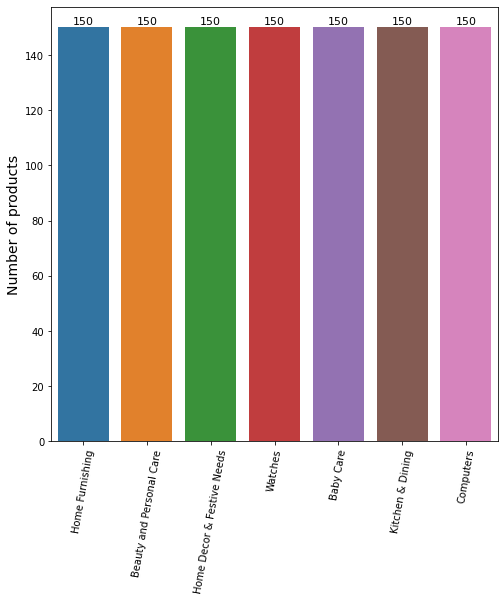

In [26]:
# Let's count the number of values under the category 1 'cat_level_0'
plt.figure(figsize=(8, 8))
    
plt.xticks(rotation=80)

first_cat_values = pd.DataFrame(data_category_levels["cat_level_0"].value_counts())


sns.barplot(x=first_cat_values.index, y=first_cat_values["cat_level_0"])

plt.ylabel("Number of products", size=14)

for i, v in enumerate(first_cat_values["cat_level_0"].values):
    plt.text(i, v+1, v, color='black', ha='center', size=11)

As we see our dat is balanced ( we have the same number of articles in every category)

Visualizing the distribution of categories

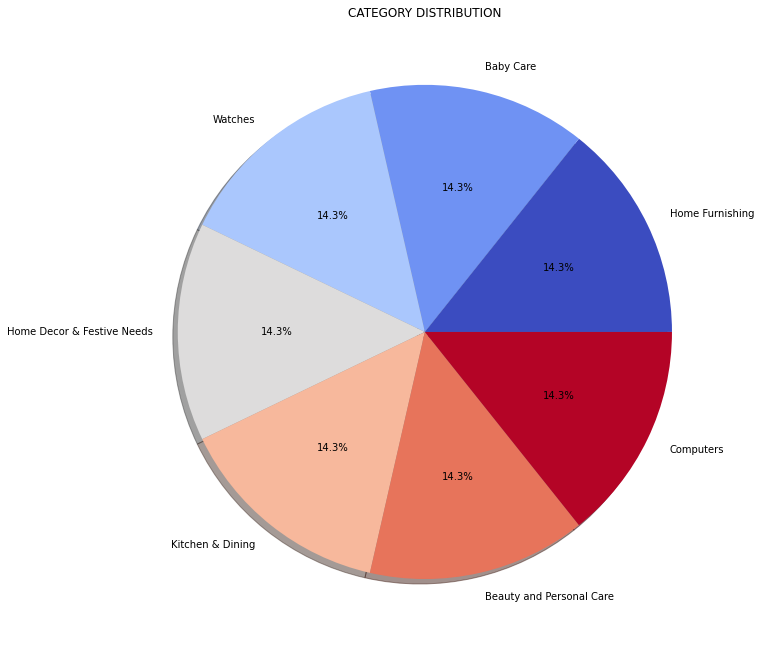

In [27]:
from matplotlib.gridspec import GridSpec
targetCounts = data_category_levels['cat_level_0'].value_counts()
targetLabels  = data_category_levels['cat_level_0'].unique()
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, 7)]
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

 ## 2) Visualizing the sub-categories

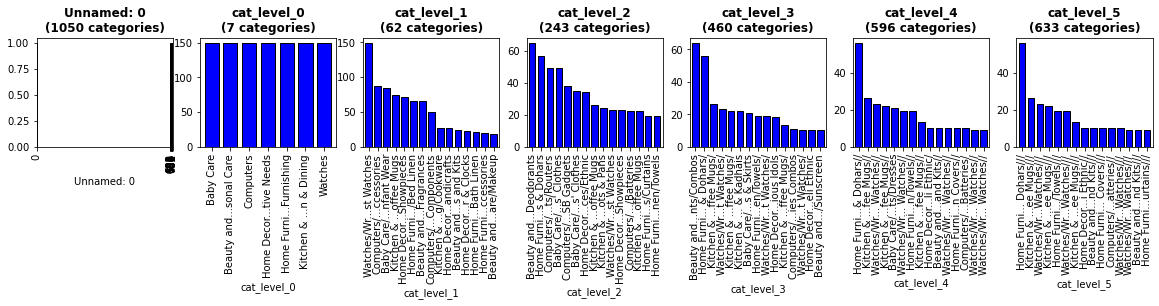

In [28]:
# Visualizing the 7 categories and their respective subcategories
fig = plt.figure(figsize=(20,2))

for counter, col in enumerate(data_category_levels.columns,1):
    # plot the graphs
    ax = fig.add_subplot(1,len(data_category_levels.columns), counter)
    ser = data_category_levels.groupby(col).size().sort_values(ascending=False)
    ser[0:15].plot.bar(width =0.75, color='blue', ec='k', ax=ax)
    # shorten the labels
    thr = int(10)
    label_x = [item.get_text() for item in ax.get_xticklabels()]
    short_lab_x = [s[:10]+'...'+s[-10:] if len(s)>10 else s for s in label_x]
    ax.axes.set_xticklabels(short_lab_x)
     # set title
    ax.set_title(col+f'\n({ser.shape[0]} categories)', fontweight='bold')

In [29]:
# finding unique values present in every category.
df = data_category_levels.columns
cat1 = data_category_levels['cat_level_0'].nunique()
cat2 = data_category_levels['cat_level_1'].nunique()
cat3 = data_category_levels['cat_level_2'].nunique()
cat4 = data_category_levels['cat_level_3'].nunique()
cat5 = data_category_levels['cat_level_4'].nunique()
cat6 = data_category_levels['cat_level_5'].nunique()
 
# printing the number of unique values present in each group
print(f'Number of unique values present in cat1: {cat1}')
print(f'Number of unique values present in cat2: {cat2}')
print(f'Number of unique values present in cat3: {cat3}')
print(f'Number of unique values present in cat4: {cat4}')
print(f'Number of unique values present in cat5: {cat5}')
print(f'Number of unique values present in cat6: {cat6}')



Number of unique values present in cat1: 7
Number of unique values present in cat2: 62
Number of unique values present in cat3: 243
Number of unique values present in cat4: 460
Number of unique values present in cat5: 596
Number of unique values present in cat6: 633


In [30]:
data_category_levels['cat_level_0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

 3) Number of unique subcategories with respect to their level

In [31]:
# Print for every category in level 0 the number of unique subcategories with respect to their level

print(data_category_levels[(data_category_levels['cat_level_0']== 'Home Furnishing')].nunique())
print(data_category_levels[(data_category_levels['cat_level_0']== 'Baby Care')].nunique())
print(data_category_levels[(data_category_levels['cat_level_0']== 'Watches')].nunique())
print(data_category_levels[(data_category_levels['cat_level_0']== 'Home Decor & Festive Needs')].nunique())
print(data_category_levels[(data_category_levels['cat_level_0']== 'Kitchen & Dining')].nunique())
print(data_category_levels[(data_category_levels['cat_level_0']== 'Beauty and Personal Care')].nunique())
print(data_category_levels[(data_category_levels['cat_level_0']== 'Computers')].nunique())


Unnamed: 0     150
cat_level_0      1
cat_level_1     11
cat_level_2     22
cat_level_3     52
cat_level_4     52
cat_level_5     52
dtype: int64
Unnamed: 0     150
cat_level_0      1
cat_level_1      9
cat_level_2     25
cat_level_3     74
cat_level_4     99
cat_level_5    133
dtype: int64
Unnamed: 0     150
cat_level_0      1
cat_level_1      2
cat_level_2     67
cat_level_3     69
cat_level_4     69
cat_level_5     69
dtype: int64
Unnamed: 0     150
cat_level_0      1
cat_level_1     10
cat_level_2     50
cat_level_3     92
cat_level_4    116
cat_level_5    117
dtype: int64
Unnamed: 0     150
cat_level_0      1
cat_level_1     11
cat_level_2     31
cat_level_3     52
cat_level_4     81
cat_level_5     81
dtype: int64
Unnamed: 0     150
cat_level_0      1
cat_level_1     11
cat_level_2     28
cat_level_3     48
cat_level_4     90
cat_level_5     92
dtype: int64
Unnamed: 0     150
cat_level_0      1
cat_level_1      8
cat_level_2     20
cat_level_3     73
cat_level_4     89
cat_level_

In [42]:

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adele\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adele\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adele\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

# II) Text preprocessing and cleaning

In [43]:
# Putting together the entire text data from the column 'description'
corpus = data['description'].str.cat(sep=' ').lower()

## 1) Remove tags, special characters and digits, stopwords, lemmatize

In [44]:
# Preprocessing steps of a text

stop_words = set(stopwords.words('english')) # What are stop words examples?
                                            # Stop words are a set of commonly used words in a language.
                                            # Examples of stop words in English are “a”, “the”, “is”, “are” and etc. 

def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    #Convert to list from string
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in stop_words]

    # remove words less than three letters
    text = [word for word in text if len(word) >= 3]

    # lemmatize (reduce words with same radical to shorter versions)
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word) for word in text]
    
    return ' '.join(text)
  

### 2) WordCloud Visualization of the most frequently repeated words in the entire text of descriptions

In [45]:
# Preprocessed text contained in 'description' column of the datframe 'data'
the_whole_text = pre_process(corpus)

In [46]:
# Add a column to the datframe data with preprocessed description text
data['preprocessed_descriptions']  = data['description'].apply(lambda x:pre_process(x))
data['preprocessed_descriptions'][0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look interior curtain made high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model duster color multicolor dimension length box number content sale package 

In [47]:
# Save new text dataframe with preprocessed text column 'preprocessed_descriptions' into a csv file
data.to_csv("data.csv")

In [79]:
data.columns

Index(['Unnamed: 0', 'uniq_id', 'product_name', 'product_category_tree',
       'image', 'description', 'preprocessed_descriptions', 'category',
       'cat_labels'],
      dtype='object')

In [72]:
#data['preprocessed_descriptions'][:]

In [70]:
#data.head(1)

In [78]:
#data['cat_labels']

In [48]:
# Preprocessed descriptions , prepared to count the most frequent words and the number of their repetition 
Sentences = data['description'].values
cleanedSentences = ""
totalWords =[]
for i in range(0,len(data)):
    cleanedText = pre_process(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        totalWords.append(word)


# Print the most frequent words   
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(20)
print(mostcommon)

[('product', 864), ('free', 618), ('buy', 581), ('delivery', 567), ('genuine', 564), ('shipping', 564), ('cash', 564), ('price', 561), ('replacement', 559), ('day', 553), ('flipkart', 481), ('com', 473), ('guarantee', 471), ('mug', 457), ('feature', 404), ('online', 396), ('specification', 379), ('color', 369), ('watch', 355), ('type', 325)]


(-0.5, 799.5, 499.5, -0.5)

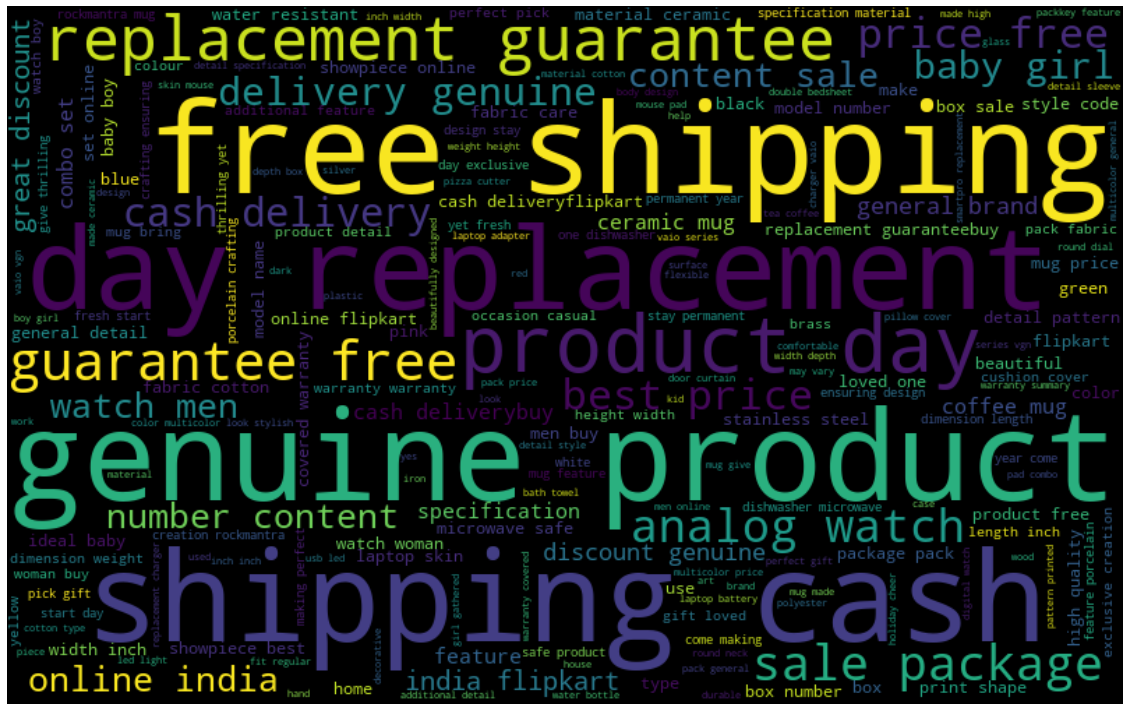

In [43]:
# Word cloud for entire dataset
wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(cleanedSentences)
plt.figure(figsize=(20, 16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

# III) Text preparation and clustering

## 1) Train Test splitting

In [136]:
# Training and testing split
from sklearn.model_selection import train_test_split

data['category'] = data_category_levels['cat_level_0']

X_train, X_test, y_train, y_test = train_test_split(data , data['category'], test_size = 0.25,random_state = 23)

In [137]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((787, 9), (263, 9), (787,), (263,))

Building a model to analyse the descriptions of the consumer goods and extract the features

***Bag of words***

We need to convert the words into a numerical format (vectors) before feeding it to our model. 
The first step is to calculate the frequency of every word in the text, then we represent these frequencies in terms of vectors.
Every word is a feature, and the vector is the count of each word (column) in every sentence (row).
One major desadvantage of Bag of Words is the abscence of semantic meaning of the words.

***TF-IDF implementation before clustering***

TF-IDF stands for Text Frequency Inverse Document Frequency and it calculates Each and avery word importance in the text.

TF is the part where we first count the number of times the word is repeated in the sentence, then this count is divided by the total number of words in the same sentence.

IDF is the step where we calculate the log(number of sentences/ number of sentences containing the words).

TF is multiplyed by IDF and we get a weighted representation (a number between 0 and 1) of each word in the text. 

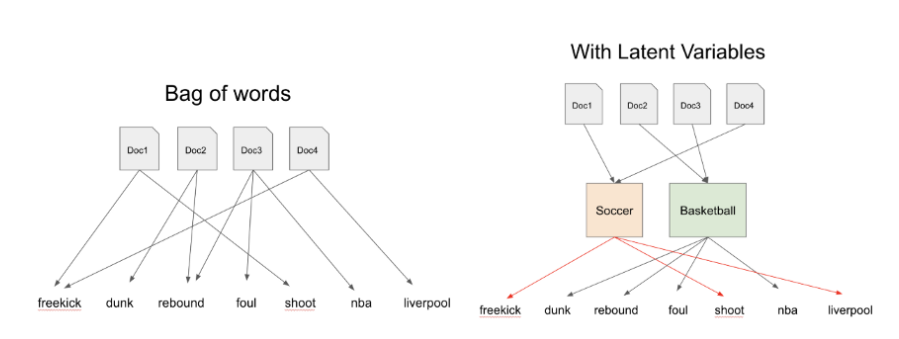

## 2) TF-IDF implementation before Kmeans clustering

In [328]:
# We are going to perform Tf-Idf vectorization on initial unprocessed description's text
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
raw_desc_tfidf= cv.fit_transform(X_train['description']).toarray()

In [329]:
raw_desc_tfidf.shape

(787, 5086)

In [330]:
raw_desc_tfidf[0]

array([0., 0., 0., ..., 0., 0., 0.])

_________________________________________________________________________________________________

In [331]:
# Let's perform Tf-Idf on processed descriptions text
preporcessed_desc_tfidf = cv.fit_transform(X_train['preprocessed_descriptions'][:]).toarray()

In [ ]:
preporcessed_desc_tfidf.shape

(787, 3811)

In [339]:
preporcessed_desc_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [334]:
# A dictionary of words ( as keys) and their number of repetition (as value)
dic_vocabulary = cv.vocabulary_

In [336]:
# Show the first key-value of our dictionary
pairs_iterator = next(iter(dic_vocabulary.items()))
pairs_iterator

('buy', 468)

In [340]:
# As we sse every word is now having it's own column (feature) 
df_prepr_desc_tfidf = pd.DataFrame(preporcessed_desc_tfidf, columns=cv.get_feature_names())
df_prepr_desc_tfidf.head()

,_blk,aapno,aari,aarika,ability,abkl_grn_grn_grn,abkl_pl_pl_pnk,abkl_pl_pnk_pnk,able,abrasion,...,zaicus,zero,zingalalaa,zip,zipper,zippered,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [341]:
# See the tfidf values for top 10 words and the last 10 words
df_max_tfidf_values = pd.DataFrame(preporcessed_desc_tfidf, columns=cv.get_feature_names()).max()
sorted_max_tfidf_values = pd.DataFrame(df_max_tfidf_values.sort_values(ascending = True))

In [342]:
df_max_tfidf_values.shape

(3811,)

In [343]:
sorted_max_tfidf_values.head(10)

,0
squeezable,0.031784
effectiveness,0.031784
beloved,0.031784
vent,0.031784
shining,0.031784
dusting,0.031784
efficient,0.031784
adjusted,0.031784
handy,0.031784
crevice,0.031784


In [344]:
sorted_max_tfidf_values.tail(10)

,0
nirlon,0.772456
brush,0.772977
unravel,0.781702
tease,0.783310
jewellery,0.793502
golmaalshop,0.826517
homedesires,0.826517
so,0.827145
shadow,0.855383
rrtc,0.888666


In [345]:
# Creat an encoded category column for kmeans training

le = preprocessing.LabelEncoder()

X_train['cat_labels'] = le.fit_transform(X_train["category"])


C:\Users\adele\AppData\Local\Temp/ipykernel_10728/2646272528.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cat_labels'] = le.fit_transform(X_train["category"])


In [346]:
# Values of unique categories made into encoded lables ranging from 0 to 6
X_train['cat_labels'].unique()

array([3, 5, 1, 0, 4, 6, 2])

 ## 3) Dimentionality reduction-PCA

In [347]:
# PCA dimentionality reduction to visualize data in 2 dimentions
pca = PCA(n_components=2)
pca_values = pca.fit_transform(df_prepr_desc_tfidf)
X_train['pca1'] =  pca_values[:,0]
X_train['pca2'] =  pca_values[:,1]

C:\Users\adele\AppData\Local\Temp/ipykernel_10728/2977964994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pca1'] =  pca_values[:,0]
C:\Users\adele\AppData\Local\Temp/ipykernel_10728/2977964994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pca2'] =  pca_values[:,1]


In [364]:
# # Let's vizualize the 2 D projection of our data 
# colors = {'Home Furnishing':'red', 'Baby Care':'green', 'Watches':'blue', 'Home Decor & Festive Needs':'yellow','Kitchen & Dining':'purple', 'Beauty and Personal Care': 'black', 'Computers':'orange'  }

# plt.scatter(X_train['pca1'], X_train['pca2'],c = X_train['category'].map(colors) ,edgecolor='none', alpha=0.5 )
# plt.xlabel('component 1')
# plt.ylabel('component 2')
# plt.colorbar()

## 4) kmeans clustering results for preporcessed descriptions after tfidf vectorization

In [362]:
 #Initialize the class object
kmeans = KMeans(n_clusters= 7, random_state = 42)
 
#predict the labels of clusters.
clusters = kmeans.fit_predict(df_prepr_desc_tfidf)
X_train['clusters'] =  clusters

C:\Users\adele\AppData\Local\Temp/ipykernel_10728/870321441.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['clusters'] =  clusters


In [363]:
# The accuracy_score calculats if the predicted label for a sample matches the corresponding set of labels in y_true.
accuracy_ = accuracy_score(X_train['cat_labels'], X_train['clusters'])
# display results
print("The accuracy_score for KMeans clustering before dimentionality reduction is : {}".format(accuracy_))
#The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples
# and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
adjusted_rand_ = adjusted_rand_score(X_train['cat_labels'], X_train['clusters'])
print("The adjusted rand score for KMeans clustering before dimentionality reduction is : {}".format(adjusted_rand_))

The accuracy_score for KMeans clustering before dimentionality reduction is : 0.13087674714104194
The adjusted rand score for KMeans clustering before dimentionality reduction is : 0.23492848003201933


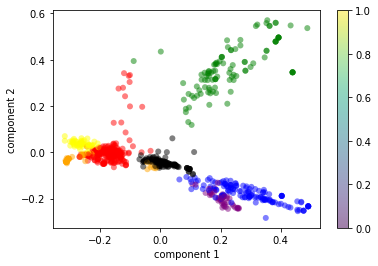

In [150]:
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow',4:'purple', 5: 'black', 6:'orange'  }

plt.scatter(X_train['pca1'], X_train['pca2'],c = X_train['clusters'].map(colors) ,edgecolor='none', alpha=0.5 )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

Conclusion:

The accuracy_score for KMeans clustering before dimentionality reduction is : 0.13087674714104194

The adjusted rand score for KMeans clustering before dimentionality reduction is : 0.23492848003201933

Let's see if we can do better

## 5) Improving the feature extraction performance for better results 
 - Select features whith the help of a pipline


In [417]:
# We want to keep only best terms before doing the Inverses Document Frequency
pipe_feature_reduction = Pipeline(steps =[('count_verctorizer',  CountVectorizer(ngram_range=(1, 2), max_features=3811)),
        ('feature_selector', SelectKBest(chi2, k=2500)),  #chi-square test “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification
        ('tfidf', TfidfTransformer(sublinear_tf=True)),
        ('kmeans_clustering', KMeans(n_clusters= 7, random_state = 0 ))])


In [418]:
pipe1_results = pipe_feature_reduction.fit(X_train['preprocessed_descriptions'],X_train['cat_labels'] )

In [419]:
pipe1_results

Pipeline(steps=[('count_verctorizer',
                 CountVectorizer(max_features=3811, ngram_range=(1, 2))),
                ('feature_selector',
                 SelectKBest(k=2500,
                             score_func=<function chi2 at 0x000002A67D6AB550>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('kmeans_clustering', KMeans(n_clusters=7, random_state=0))])

In [420]:
X_train['pipe_clusters'] = pipe_feature_reduction.predict(X_train['preprocessed_descriptions'])

C:\Users\adele\AppData\Local\Temp/ipykernel_10728/211518307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pipe_clusters'] = pipe_feature_reduction.predict(X_train['preprocessed_descriptions'])


In [423]:
accuracy_pipe = accuracy_score(X_train['cat_labels'], X_train['pipe_clusters'])
print("The accuracy_score for KMeans clustering before dimentionality reduction is : {}".format(accuracy_pipe))

#ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
adjusted_rand_pipe = adjusted_rand_score(X_train['cat_labels'], X_train['pipe_clusters'])
print("The adjusted rand score for KMeans clustering before dimentionality reduction is : {}".format(adjusted_rand_pipe))

The accuracy_score for KMeans clustering before dimentionality reduction is : 0.156289707750953
The adjusted rand score for KMeans clustering before dimentionality reduction is : 0.2730907775765705


We see that the performances have a little improved affter feature extraction adjustements, but let's try some other methods.



**LDA Model Implementation**

Latent Dirichlet Allocation
“generative probabilistic model of a corpus.” = a statistical technique that can extract underlying themes/topics from a corpus.

In a traditional Bag-of-words approach for text feature extraction, we map each document directly to all the word tokens through a Document-Term matrix. This approach often results in a huge, sparse matrix with the majority of entries equal 0 — we have lots of parameters to estimate when we use such a matrix as model inputs, but many of them provide limited and sometimes “noisy” information.

In the LDA approach, instead of modeling the relationships between each text document and each word token directly, the “Latent variables” are introduced as “bridges.” Each document within the corpus is characterized by a Dirichlet distribution over the latent variables (topics) and each topic is characterized by another Dirichlet Distribution over all the word tokens.

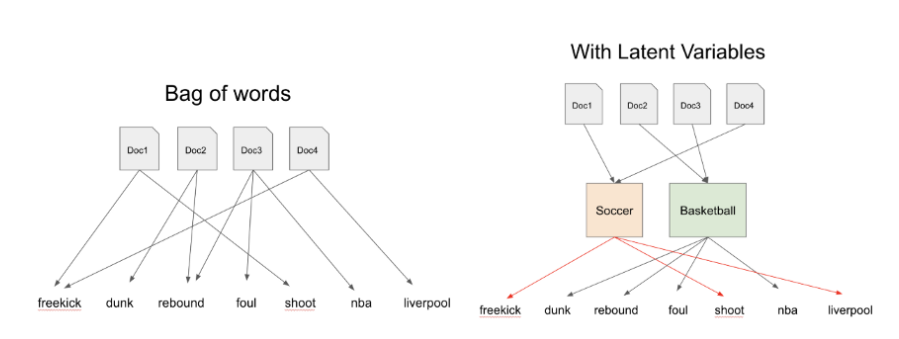

For each document, we can obtain a vector of length K which represents the probability distribution of the document over K topics. Appending such vectors for all the documents, we can get an N-by-K feature matrix that can be input into our supervised model with certain labels.


## IV) Unsupervised Learning with LDA (Latent Dirichlet Allocation) Topic Modeling

        1) Phrase Modeling: Bi-grams and Tri-grams
                Given a sequence of N-1 words, an N-gram model predicts the most probable word that might follow this sequence
        
        2) Data Transformation: Corpus and Dictionary
                calculating Term Document Frequency
        3) Creating a Base Model and calculating it's Coherence score
        4) Hyper-parameter Tuning
        5) Final model
        6) Visualize the results of  topics-keywords with pyLDAvis

 ## 1) Phrase Modeling: Bi-grams and Tri-grams
                Given a sequence of N-1 words, an N-gram model predicts the most probable word that might follow this sequence

In [424]:
# Preparing the data
texts = X_train["preprocessed_descriptions"]

## create list of lists of unigrams
lst_corpus = [] # list of comma separated words in each row (len(X_train))
for string in texts:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## 2) Data Transformation: Corpus and Dictionary
                calculating Term Document Frequency

In [425]:
# See the frequency of every word in a document
# Create Dictionary of unique words in our corpus 
id2word = gensim.corpora.Dictionary(lst_corpus)
# Create Corpus
texts = lst_corpus
# Term Document Frequency = every row here is a document and a column is a word
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 2)]]


In [426]:
len(corpus)

787

## 3) Creating a Base Model and calculating it's Coherence score

In [427]:
# Creating a Base  Model
# The above LDA model is built with è different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

tf = cv.fit_transform(X_train['preprocessed_descriptions'][:]).toarray()

# Setting the number of topics equal to number of categories
n_topics = 7

# Instanciate LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                        alpha="auto")

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)


In [428]:
# See the keywords for each topic and the weightage(importance) of each keyword
# Every topic is represented as a distribution over words
from pprint import pprint

# Print the Keyword in the è topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"watch" + 0.033*"product" + 0.032*"day" + 0.031*"free" + '
  '0.031*"replacement" + 0.030*"buy" + 0.030*"guarantee" + 0.030*"delivery" + '
  '0.030*"cash" + 0.030*"shipping"'),
 (1,
  '0.017*"warranty" + 0.011*"product" + 0.010*"curtain" + 0.010*"feature" + '
  '0.009*"polyester" + 0.009*"bottle" + 0.008*"price" + 0.008*"water" + '
  '0.008*"eyelet" + 0.008*"door"'),
 (2,
  '0.044*"mug" + 0.028*"laptop" + 0.020*"coffee" + 0.017*"perfect" + '
  '0.017*"quality" + 0.017*"ceramic" + 0.015*"also" + 0.014*"one" + '
  '0.012*"gift" + 0.011*"power"'),
 (3,
  '0.022*"inch" + 0.021*"color" + 0.020*"pack" + 0.018*"feature" + '
  '0.018*"material" + 0.017*"box" + 0.017*"package" + 0.016*"sale" + '
  '0.016*"number" + 0.016*"specification"'),
 (4,
  '0.025*"skin" + 0.014*"sheet" + 0.013*"type" + 0.013*"set" + 0.011*"combo" + '
  '0.011*"print" + 0.010*"size" + 0.009*"hair" + 0.009*"bed" + 0.009*"easy"'),
 (5,
  '0.045*"flipkart" + 0.045*"com" + 0.043*"product" + 0.039*"free" + '
  '0

   ## Compute Model Perplexity and Coherence Score for the Base Model
    
   Perplexity =  how well does the model represent or reproduce the statistics of the held-out data.
                 A lower perplexity score indicates better generalization performance.
   
   Coherence score = Measures single topic by measuring the degree of semantic similarity between high scoring words in the topic.
                     These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. 

In [430]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5260387760008169


   ## 4) Hyper-parameter Tuning
    Finding the best hyperparameters for our LDA Model:
    
        - Number of Topics (K)
        - Dirichlet hyperparameter alpha: Document-Topic Density
        - Dirichlet hyperparameter beta: Word-Topic Densityalpha,
    
        
    Let's call the function, and iterate it over the range of topics, alpha, and beta parameter values

In [431]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [210]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 5
max_topics = 9
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [55:47<00:00, 13.95s/it]


In [432]:
# Saving the results
df_results =pd.DataFrame(model_results)
df_results.to_csv("df_results.csv")

In [212]:
df_results

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,5,0.01,0.01,0.635002
1,75% Corpus,5,0.01,0.31,0.603502
2,75% Corpus,5,0.01,0.61,0.569525
3,75% Corpus,5,0.01,0.91,0.594343
4,75% Corpus,5,0.01,symmetric,0.627947
5,75% Corpus,5,0.31,0.01,0.616732
6,75% Corpus,5,0.31,0.31,0.597631
7,75% Corpus,5,0.31,0.61,0.587506
8,75% Corpus,5,0.31,0.91,0.565383
9,75% Corpus,5,0.31,symmetric,0.602974


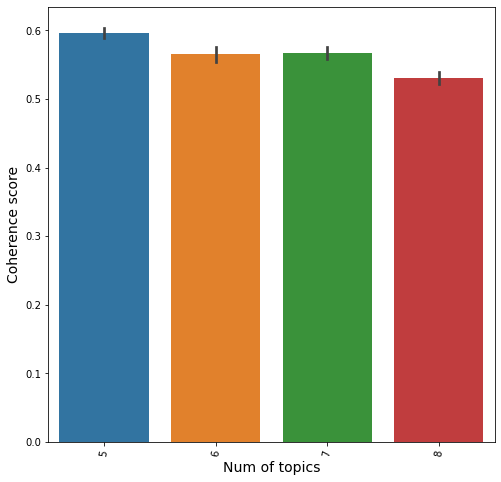

In [434]:
# Let's the coherence scores for topics from 5 to 8
plt.figure(figsize=(8, 8))
    
plt.xticks(rotation=80)

sns.barplot(x=df_results['Topics'], y=df_results['Coherence'])
plt.xlabel("Num of topics", size=14)
plt.ylabel("Coherence score", size=14)
#plt.legend("Coherence_values")
plt.show()

### We see that for number of topics 5 the coherence score is the most high
###  Based on observation on the df_results, the best hyperparameters are : alpha='symmetric', beta=0.31	with coherence score = 0.660307

## 5) Final model

In [446]:
num_topics = 5

lda_final_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           eta=0.31)

In [449]:
# Compute Perplexity ==> the lower the better
perplexity_score_final = lda_final_model.log_perplexity(corpus)  # a measure of how good the model is. lower the better 
print("The perplexity score is : {}".format(perplexity_score_final))
    
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda_final = CoherenceModel(model=lda_final_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda_final = coherence_model_lda_final.get_coherence()
print("The coherence  score is : {}".format(coherence_lda_final))

The perplexity score is : -6.674963053284015
The coherence  score is : 0.6006007790662439


In [78]:
!pip install pyLDAvis==2.1.2

In [189]:
lda_model.print_topics()

[(0,
  '0.036*"watch" + 0.033*"product" + 0.032*"day" + 0.031*"free" + 0.031*"replacement" + 0.030*"buy" + 0.030*"guarantee" + 0.030*"delivery" + 0.030*"cash" + 0.030*"shipping"'),
 (1,
  '0.017*"warranty" + 0.011*"product" + 0.010*"curtain" + 0.010*"feature" + 0.009*"polyester" + 0.009*"bottle" + 0.008*"price" + 0.008*"water" + 0.008*"eyelet" + 0.008*"door"'),
 (2,
  '0.044*"mug" + 0.028*"laptop" + 0.020*"coffee" + 0.017*"perfect" + 0.017*"quality" + 0.017*"ceramic" + 0.015*"also" + 0.014*"one" + 0.012*"gift" + 0.011*"power"'),
 (3,
  '0.022*"inch" + 0.021*"color" + 0.020*"pack" + 0.018*"feature" + 0.018*"material" + 0.017*"box" + 0.017*"package" + 0.016*"sale" + 0.016*"number" + 0.016*"specification"'),
 (4,
  '0.025*"skin" + 0.014*"sheet" + 0.013*"type" + 0.013*"set" + 0.011*"combo" + 0.011*"print" + 0.010*"size" + 0.009*"hair" + 0.009*"bed" + 0.009*"easy"'),
 (5,
  '0.045*"flipkart" + 0.045*"com" + 0.043*"product" + 0.039*"free" + 0.034*"delivery" + 0.034*"shipping" + 0.034*"cash" 

In [116]:
!pip install --upgrade pandas==1.2

  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4


## 6) Visualize the results of  topics-keywords with pyLDAvis

In [448]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_final_model, corpus, id2word, mds="mmds", R=30)

vis

C:\Users\adele\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.110378  0.257445       1        1  23.488941
1     -0.081287 -0.203042       2        1  23.211768
4     -0.169002 -0.031339       3        1  18.631639
2      0.191178 -0.147006       4        1  18.541856
0      0.169488  0.123942       5        1  16.125795, topic_info=               Term        Freq       Total Category  logprob  loglift
24              mug  322.000000  322.000000  Default  30.0000  30.0000
4              cash  305.000000  305.000000  Default  29.0000  29.0000
16         shipping  305.000000  305.000000  Default  28.0000  28.0000
8           genuine  305.000000  305.000000  Default  27.0000  27.0000
6          delivery  305.000000  305.000000  Default  26.0000  26.0000
3               buy  311.000000  311.000000  Default  25.0000  25.0000
28              com  274.000000  274.000000  Default  24.0000  24.0000
32         flipkart  277.000000  277.000000  Default  23.0000  23.0000
170           watch  260.000000  260.000000  Default  22.0000  22.0000
7              free  336.000000  336.000000  Default  21.0000  21.0000
10        guarantee  251.000000  251.000000  Default  20.0000  20.0000
39             baby  216.000000  216.000000  Default  19.0000  19.0000
164          analog  218.000000  218.000000  Default  18.0000  18.0000
15      replacement  278.000000  278.000000  Default  17.0000  17.0000
12           online  213.000000  213.000000  Default  16.0000  16.0000
231             usb  141.000000  141.000000  Default  15.0000  15.0000
5               day  304.000000  304.000000  Default  14.0000  14.0000
14          product  458.000000  458.000000  Default  13.0000  13.0000
527          coffee  121.000000  121.000000  Default  12.0000  12.0000
22          ceramic  156.000000  156.000000  Default  11.0000  11.0000
53             girl  217.000000  217.000000  Default  10.0000  10.0000
48           detail  203.000000  203.000000  Default   9.0000   9.0000
49           fabric  190.000000  190.000000  Default   8.0000   8.0000
1259        curtain  104.000000  104.000000  Default   7.0000   7.0000
626        warranty  170.000000  170.000000  Default   6.0000   6.0000
399         perfect  138.000000  138.000000  Default   5.0000   5.0000
166        discount  102.000000  102.000000  Default   4.0000   4.0000
169           india  110.000000  110.000000  Default   3.0000   3.0000
117             men  134.000000  134.000000  Default   2.0000   2.0000
723          laptop  160.000000  160.000000  Default   1.0000   1.0000
166        discount  101.112582  102.722632   Topic1  -4.5430   1.4328
322            dial   85.997470   87.611834   Topic1  -4.7050   1.4300
28              com  267.289935  274.190925   Topic1  -3.5709   1.4231
164          analog  212.378555  218.065550   Topic1  -3.8009   1.4222
857          sonata   36.707622   37.927151   Topic1  -5.5563   1.4160
32         flipkart  267.986843  277.034610   Topic1  -3.5683   1.4154
4              cash  295.057928  305.039170   Topic1  -3.4721   1.4154
16         shipping  295.017379  305.043684   Topic1  -3.4722   1.4152
170           watch  252.121653  260.695452   Topic1  -3.6294   1.4152
8           genuine  294.996936  305.040099   Topic1  -3.4723   1.4152
6          delivery  294.949042  305.845188   Topic1  -3.4725   1.4124
629           clasp   31.965235   33.331133   Topic1  -5.6946   1.4068
1805        timewel   29.011687   30.272095   Topic1  -5.7916   1.4061
169           india  106.301535  110.948269   Topic1  -4.4930   1.4059
3624      vibrantly   24.479878   25.665777   Topic1  -5.9614   1.4013
10        guarantee  239.705961  251.454292   Topic1  -3.6799   1.4008
326           strap   83.136119   87.291176   Topic1  -4.7388   1.3999
628          buckle   25.974043   27.372708   Topic1  -5.9022   1.3962
3               buy  294.721093  311.227309   Topic1  -3.4733   1.3941
3623       tresemme   20.4405

The area of circle represents the importance of each topic over the entire corpus, the distance between the center of circles indicate the similarity between topics. For each topic, the histogram on the right side lists the top 30 most relevant terms.

In Red bars is given the frequency of each word given a topic
We can also rerank words and introduce new words tnat are more specific to a topic of interest, we do that by decreasing the value of lambda
We are putting more weight to frequency given the topic to the overall frequency of the word
If we hover over a certain word we can also see where in which topics this word is also present, by doing this we show the unexplained (grey part) of the frequency, the topics will show up when we hover over the word of interest

# V) Some other Modeling strategies : XGBoost

In [177]:
from sklearn.feature_extraction.text import CountVectorizer
vec_count = CountVectorizer(ngram_range = (1,1))
vec_count_f = vec_count.fit(X_train['preprocessed_descriptions'][:])

In [257]:
# Create the training document-term matrix for LDA weights
vec_f = vec_count_f
train_dtm = vec_f.transform(X_train['preprocessed_descriptions'][:])
topic_num = 7
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = topic_num)
lda_f = lda.fit(train_dtm)
lda_weights = lda_f.transform(train_dtm)
# The lda_weights is a n by k matrix where n is the number of documents and k is the number of topics
# Fit the xgb-model with lda weights
from xgboost import XGBClassifier
xgbc = XGBClassifier(n_estimators=200)
xgbc_lda = xgbc.fit(lda_weights,X_train['cat_labels'])
y_pred_X_train = xgbc.predict(lda_weights)

In [270]:
y_train_original = X_train['cat_labels']
accuracy = accuracy_score(y_train_original, y_pred_X_train)
accuracy

1.0

In [274]:
# preparing the tets data for lda model 
# Create the training document-term matrix for LDA weights
vec_f = vec_count_f
test_dtm = vec_f.transform(X_test['preprocessed_descriptions'][:])
topic_num = 7
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = topic_num)
lda_f = lda.fit(test_dtm)
lda_weights_X_test = lda_f.transform(test_dtm)
y_pred_X_test = xgbc.predict(lda_weights_X_test)

In [275]:
y_test_original = X_test['cat_labels']

In [276]:
accuracy = accuracy_score(y_test_original, y_pred_X_test)
accuracy

0.26996197718631176

In [ ]:
Kmeans model on LDA outcome = 

In [278]:
 #Initialize the class object
kmeans = KMeans(n_clusters= 7)
 
#predict the labels of clusters.
clusters = kmeans.fit_predict(lda_weights)
#X_train['clusters'] =  clusters

In [279]:
# The accuracy_score calculats if the predicted label for a sample matches the corresponding set of labels in y_true.
accuracy_score(X_train['cat_labels'], clusters)

0.16772554002541296